# Bank Customer Complaint Analysis

This project analyzes customer complaints submitted to the Consumer Financial Protection Bureau across five product categories: credit reporting, debt collection, mortgages and loans, credit cards, and retail banking. Using Natural Language Processing (NLP) techniques including text preprocessing, sentiment analysis, and machine learning, we classify complaint narratives to understand patterns and create a system that could efficiently route complaints to appropriate teams, improving response times and customer satisfaction.

In [1]:
# Data Loading & Cleaning
import pandas as pd
import numpy as np
import nltk
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLTK
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import TreebankWordTokenizer

from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Visulalize Data
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Data Loading and Initial Exploration

In [36]:
df = pd.read_csv('Datasets/complaints.csv')


df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [38]:
df.shape

(162421, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [5]:
df.isnull().sum()

,0
Unnamed: 0,0
product,0
narrative,10


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.describe()

,Unnamed: 0
count,162421.000000
mean,81210.000000
std,46887.048373
min,0.000000
25%,40605.000000
50%,81210.000000
75%,121815.000000
max,162420.000000


## 2. Data Preprocessing

In [8]:
# Rename the "Unnamed: 0" column
df = df.rename(columns={"Unnamed: 0": "complaint_id"})

In [9]:
# Drop rows with missing narratives
df = df.dropna(subset=['narrative'])

In [10]:
# Check the distribution of product categories
product_distribution = df['product'].value_counts()
print(product_distribution)

product
credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: count, dtype: int64


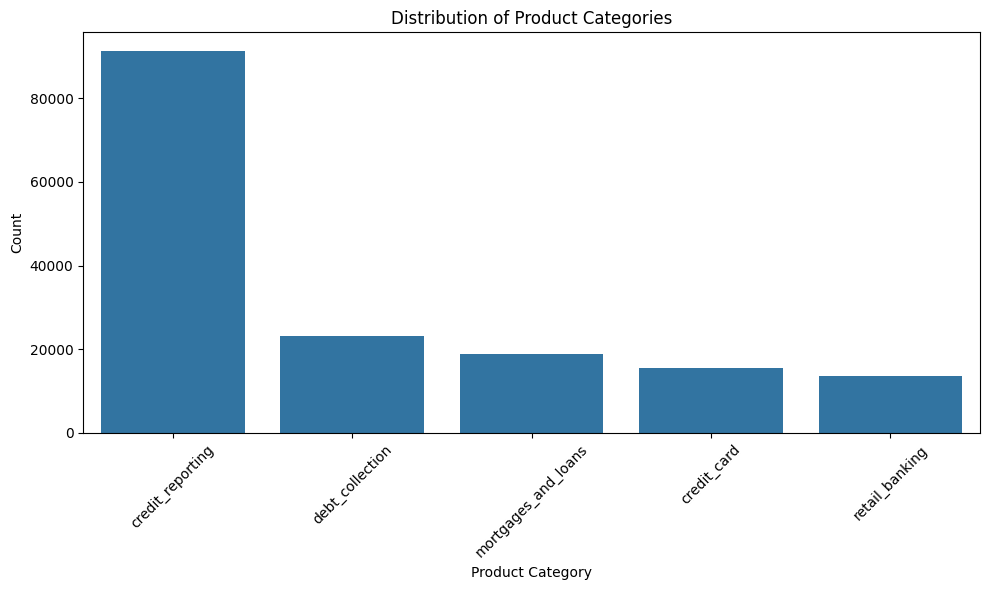

In [11]:
# Visualize the distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=product_distribution.index, y=product_distribution.values)
plt.title('Distribution of Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Text Preprocessing

In [12]:

tokenizer = TreebankWordTokenizer()

def clean_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = tokenizer.tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply cleaning function to the narrative column
df['cleaned_narrative'] = df['narrative'].apply(clean_text)

# Check a few examples to make sure it worked
for i in range(3):
    print(f"Original: {df['narrative'].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_narrative'].iloc[i][:100]}...")
    print()

Original: purchase order day shipping amount receive product week sent followup email exact verbiage paid two ...
Cleaned: purchas order day ship amount receiv product week sent followup email exact verbiag paid two day shi...

Original: forwarded message date tue subject please investigate comenity bank retailer card scam sent hello na...
Cleaned: forward messag date tue subject pleas investig comen bank retail card scam sent hello name scam come...

Original: forwarded message cc sent friday pdt subject final legal payment well fargo well fargo clearly wrong...
Cleaned: forward messag cc sent friday pdt subject final legal payment well fargo well fargo clearli wrong ne...



## 4. Word Cloud Visualization and Term Frequency Analysis by Product Category


Most common words for credit_card:
card: 37863
credit: 34178
account: 28773
call: 19720
charg: 18434
payment: 17876
bank: 14569
receiv: 14037
would: 13002
time: 12982
one: 11316
told: 10096
disput: 9916
balanc: 8666
day: 8554
close: 8465
report: 8412
get: 8404
inform: 8259
use: 8176


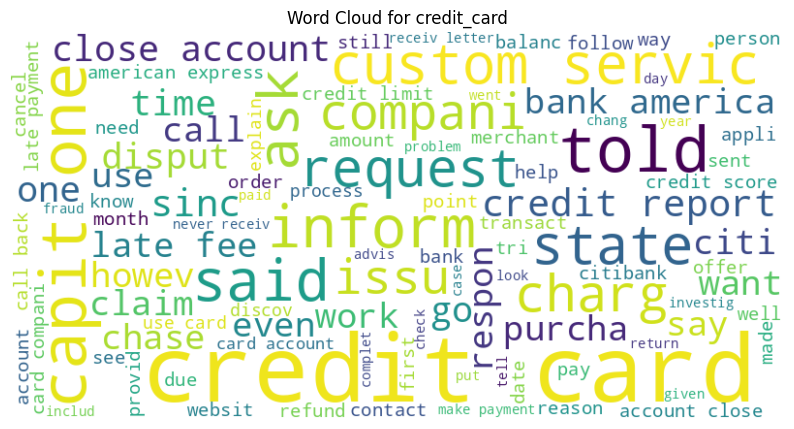


Most common words for retail_banking:
account: 45716
bank: 28001
money: 15977
check: 15487
call: 15177
receiv: 11015
would: 10501
day: 9942
told: 9681
fund: 9524
time: 8863
transact: 8171
deposit: 8043
back: 8043
card: 7976
close: 7597
get: 7483
transfer: 7315
inform: 7129
email: 6531


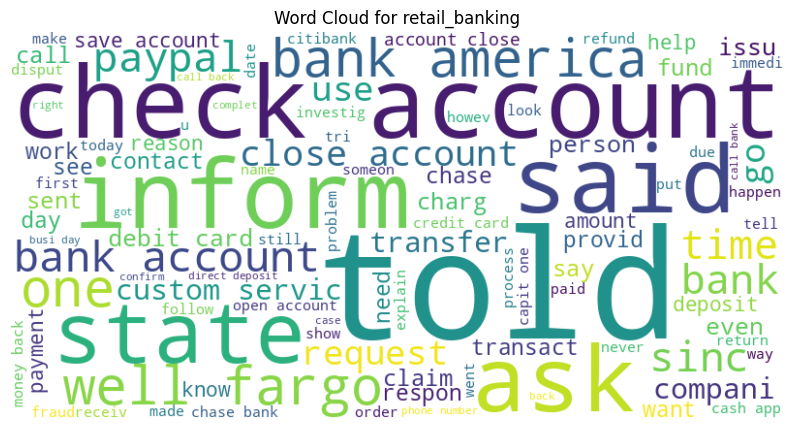


Most common words for credit_reporting:
report: 250389
credit: 226523
account: 189945
inform: 113933
disput: 60056
remov: 59222
consum: 50271
payment: 45660
file: 45599
request: 41418
receiv: 40034
letter: 39077
day: 39052
bureau: 38405
inquiri: 36405
compani: 35223
agenc: 35200
item: 35114
time: 34837
open: 34720


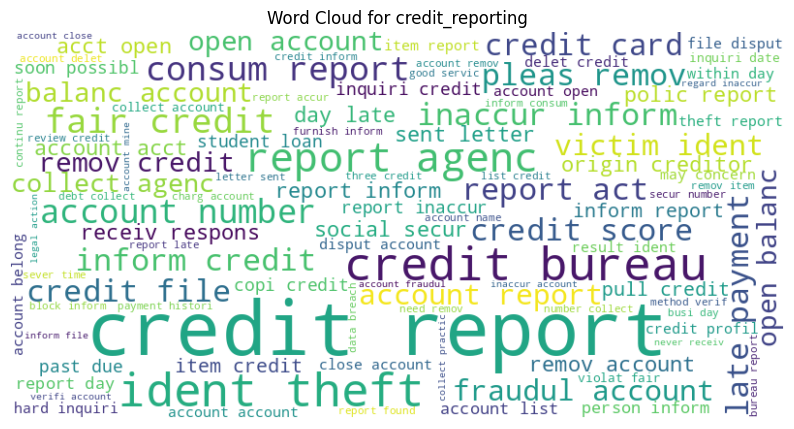


Most common words for mortgages_and_loans:
payment: 47361
loan: 44232
call: 28128
mortgag: 26654
would: 22594
account: 19828
time: 19263
receiv: 18927
credit: 16389
told: 15639
pay: 14661
compani: 14552
month: 14199
get: 13475
inform: 13213
servic: 12813
request: 12667
day: 12606
bank: 12598
due: 12186


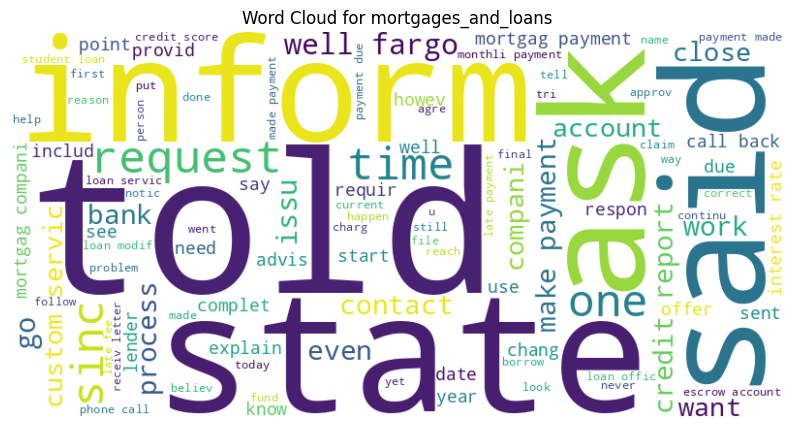


Most common words for debt_collection:
debt: 42665
credit: 39352
report: 35660
account: 35086
collect: 29126
call: 21916
inform: 19164
compani: 18873
receiv: 16077
letter: 12420
provid: 12228
payment: 11996
time: 11712
request: 11258
state: 11019
owe: 10568
disput: 10422
never: 10065
contact: 9824
would: 9696


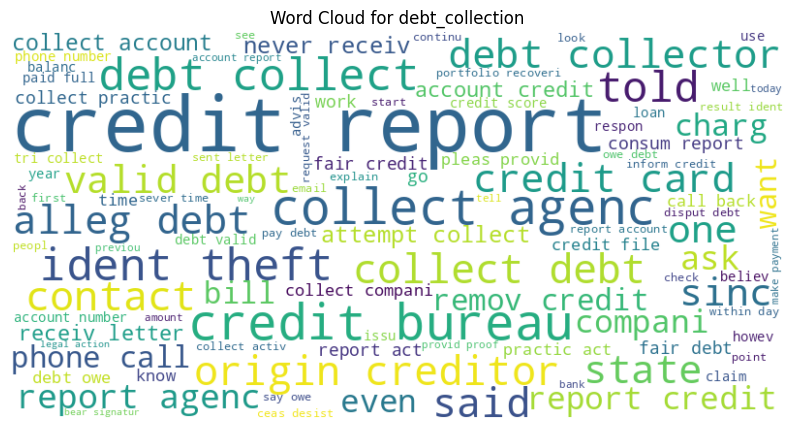

In [13]:
# explore the frequency of words in each product category
from collections import Counter
from wordcloud import WordCloud

# Create a dictionary to store word frequencies for each product category
product_word_freq = {}

for product in df['product'].unique():
    product_text = ' '.join(df[df['product'] == product]['cleaned_narrative'])
    words = product_text.split()
    word_counts = Counter(words)

    product_word_freq[product] = word_counts.most_common(20)

    print(f"\nMost common words for {product}:")
    for word, count in product_word_freq[product]:
        print(f"{word}: {count}")

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(product_text)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {product}')
    plt.axis('off')
    plt.show()





### Top 10 Most Frequent Words

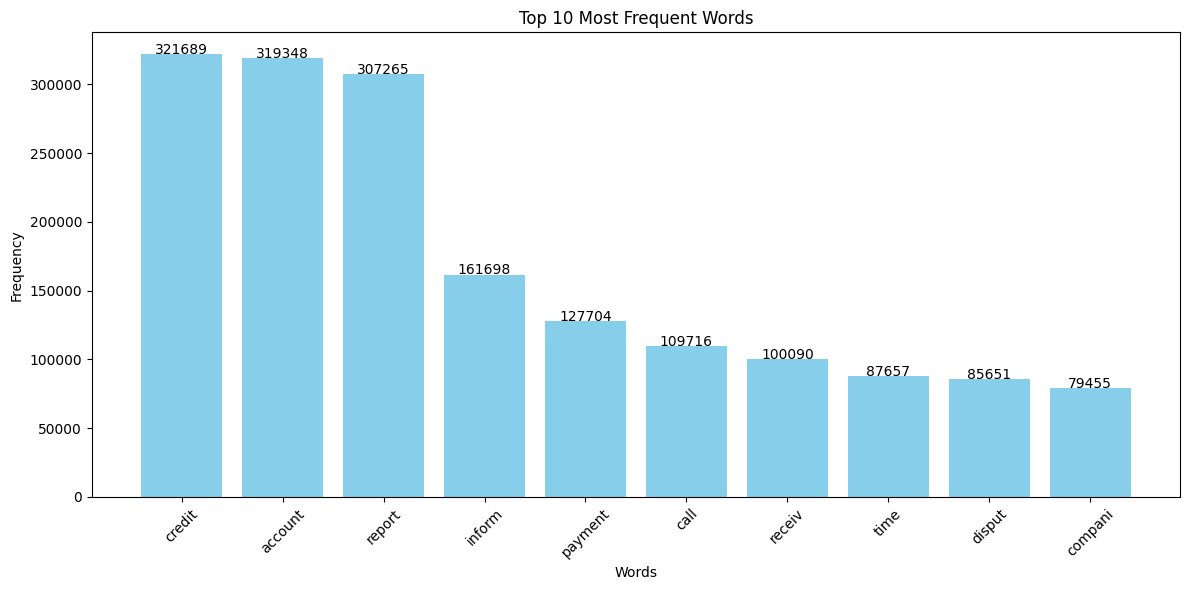

In [14]:
# Get the frequency of all words across all product categories
all_text = ' '.join(df['cleaned_narrative'])
all_words = all_text.split()
all_word_counts = Counter(all_words)

# Get the top 10 most frequent words
top_10_words = all_word_counts.most_common(10)

# Create lists for plotting
words = [word for word, count in top_10_words]
counts = [count for word, count in top_10_words]

# Create a simple bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Add count labels above each bar
for i, count in enumerate(counts):
    plt.text(i, count + 100, str(count), ha='center')

plt.tight_layout()
plt.show()

## 5. Sentiment Analysis


Sentiment rating distribution:
sentiment_rating
1    34713
2    22238
3    23609
4    29689
5    52162
Name: count, dtype: int64


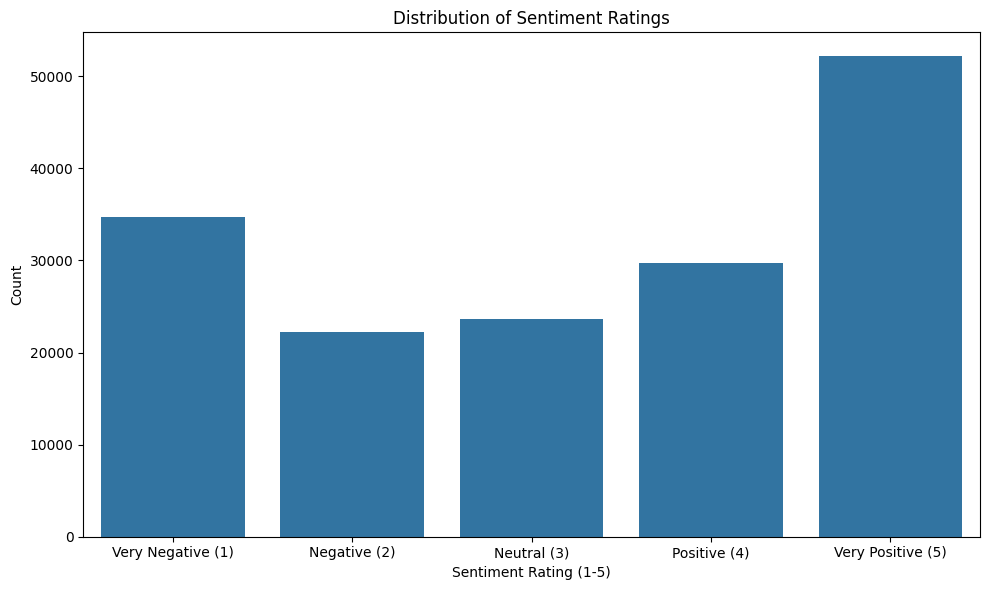


Average sentiment by product category:
product
debt_collection       -0.107547
retail_banking        -0.042199
credit_reporting       0.159963
credit_card            0.179685
mortgages_and_loans    0.186595
Name: sentiment_score, dtype: float64


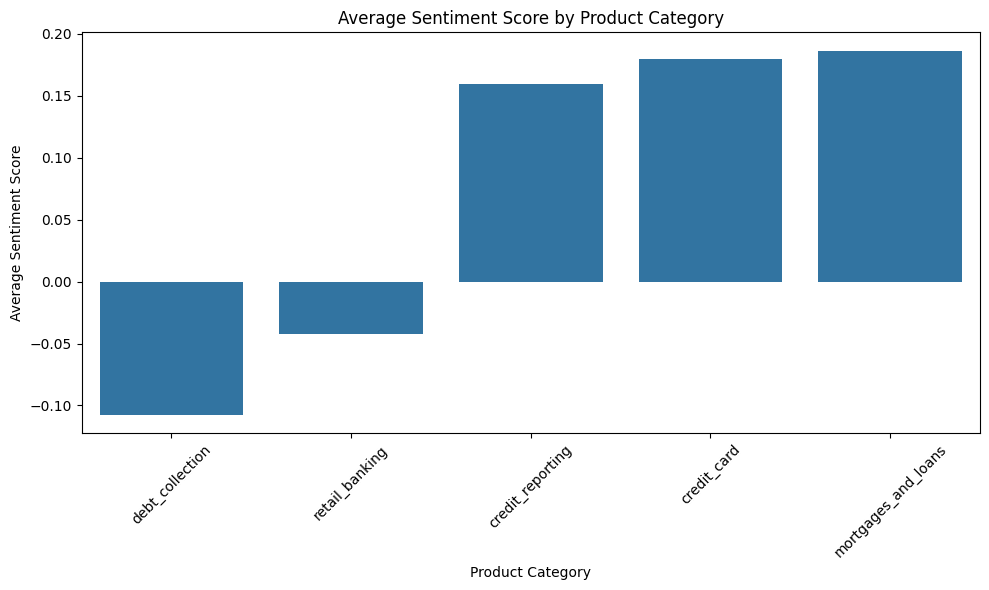

In [15]:
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Function to map sentiment score to a 1-5 scale
def map_sentiment_to_scale(score):
    if score <= -0.6:
        return 1
    elif score <= -0.2:
        return 2
    elif score <= 0.2:
        return 3
    elif score <= 0.6:
        return 4
    else:
        return 5

# Apply sentiment analysis to narratives
df['sentiment_score'] = df['narrative'].apply(get_sentiment_score)
df['sentiment_rating'] = df['sentiment_score'].apply(map_sentiment_to_scale)

# Display sentiment distribution
print("\nSentiment rating distribution:")
sentiment_counts = df['sentiment_rating'].value_counts().sort_index()
print(sentiment_counts)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Sentiment Ratings')
plt.xlabel('Sentiment Rating (1-5)')
plt.ylabel('Count')
plt.xticks(range(5), ['Very Negative (1)', 'Negative (2)', 'Neutral (3)', 'Positive (4)', 'Very Positive (5)'])
plt.tight_layout()
plt.show()

# Check average sentiment by product category
print("\nAverage sentiment by product category:")
avg_sentiment = df.groupby('product')['sentiment_score'].mean().sort_values()
print(avg_sentiment)

# Visualize average sentiment by product
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_sentiment.index, y=avg_sentiment.values)
plt.title('Average Sentiment Score by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Feature Extraction

In [16]:
# Create TF-IDF features from the cleaned narratives
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_narrative'])

# Display the shape of the feature matrix
print(f"Shape of TF-IDF feature matrix: {X_tfidf.shape}")

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features (words): {len(feature_names)}")
print(f"Sample features: {list(feature_names)[:10]}...")

# Create a label encoder
label_encoder = LabelEncoder()

# Create a new column with encoded product categories
df['product_encoded'] = label_encoder.fit_transform(df['product'])

# Show the mapping between categories and numerical labels
print("\nEncoding mapping for product categories:")
for i, category in enumerate(label_encoder.classes_):
    print(f"{category} -> {i}")


Shape of TF-IDF feature matrix: (162411, 5000)
Number of features (words): 5000
Sample features: ['aa', 'aadvantag', 'aag', 'aargon', 'ab', 'abandon', 'abbrevi', 'abet', 'abid', 'abil']...

Encoding mapping for product categories:
credit_card -> 0
credit_reporting -> 1
debt_collection -> 2
mortgages_and_loans -> 3
retail_banking -> 4


In [17]:
df[['product', 'product_encoded']].head()

,product,product_encoded
0,credit_card,0
1,credit_card,0
2,retail_banking,4
3,credit_reporting,1
4,credit_reporting,1


In [18]:
y = df['product_encoded']

print(f"\nShape of target variable: {y.shape}")


Shape of target variable: (162411,)


## 7. Model Development

In [34]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Find the best model
models = {
    'Naive Bayes': (nb_model, nb_accuracy),
    'Logistic Regression': (lr_model, lr_accuracy),
    'Random Forest': (rf_model, rf_accuracy)
}

best_model_name = max(models, key=lambda k: models[k][1])
best_model, best_accuracy = models[best_model_name]

print(f"\nBest model: {best_model_name} with accuracy {best_accuracy:.4f}")

Training set shape: (129928, 5000)
Testing set shape: (32483, 5000)
Naive Bayes Accuracy: 0.8333
Logistic Regression Accuracy: 0.8703
Random Forest Accuracy: 0.8821

Best model: Random Forest with accuracy 0.8821


## 8. Model Evaluation

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      3132
           1       0.89      0.97      0.93     18283
           2       0.89      0.72      0.80      4615
           3       0.87      0.80      0.83      3770
           4       0.86      0.85      0.86      2683

    accuracy                           0.88     32483
   macro avg       0.87      0.81      0.84     32483
weighted avg       0.88      0.88      0.88     32483



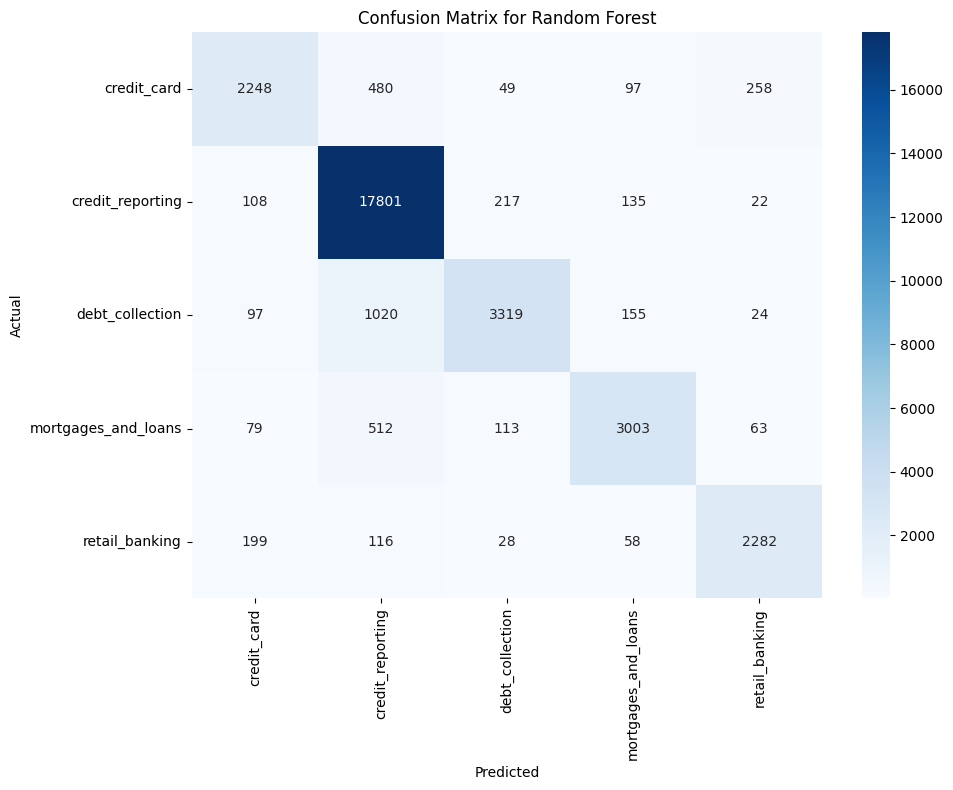

In [20]:

# Get predictions using the best model
y_pred = best_model.predict(X_test)

# Print classification report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Map numeric labels back to product categories for better visualization
product_names = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=product_names,
            yticklabels=product_names)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

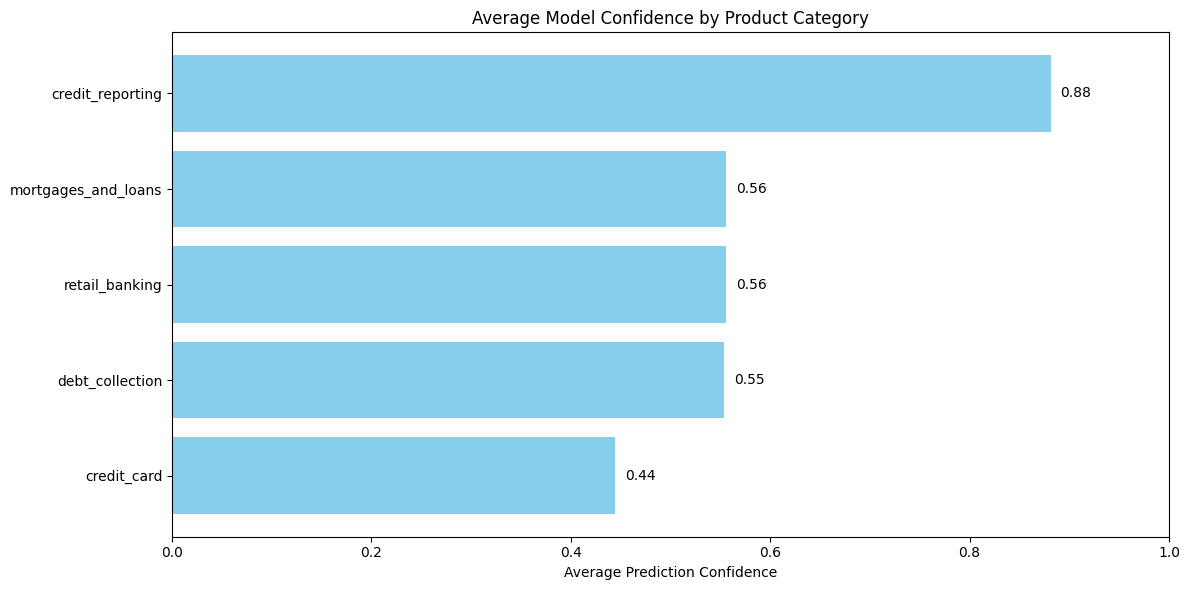

In [29]:
# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_test)

# Calculate average confidence for each category
avg_confidence = {}
for i, category in enumerate(label_encoder.classes_):

    category_indices = np.where(y_test == i)[0]
    category_confidences = [y_pred_proba[idx][i] for idx in category_indices]
    avg_confidence[category] = np.mean(category_confidences)

plt.figure(figsize=(12, 6))
categories = list(avg_confidence.keys())
confidences = list(avg_confidence.values())

sorted_indices = np.argsort(confidences)
sorted_categories = [categories[i] for i in sorted_indices]
sorted_confidences = [confidences[i] for i in sorted_indices]

bars = plt.barh(sorted_categories, sorted_confidences, color='skyblue')
plt.xlabel('Average Prediction Confidence')
plt.title('Average Model Confidence by Product Category')
plt.xlim(0, 1.0)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             ha='left',
             va='center')

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

Top 20 most important features:
      Feature  Importance
3654   report    0.032531
1008   credit    0.024389
1082     debt    0.024088
2528     loan    0.018170
608      card    0.017829
790   collect    0.015436
374      bank    0.014246
2789  mortgag    0.013386
586      call    0.011010
37    account    0.010531
2773    money    0.010037
3631    remov    0.009892
3061      owe    0.007712
3128  payment    0.007606
1828     fund    0.007317
564    bureau    0.006487
3121      pay    0.006408
1151  deposit    0.005917
4433     told    0.005430
2230   inform    0.005413


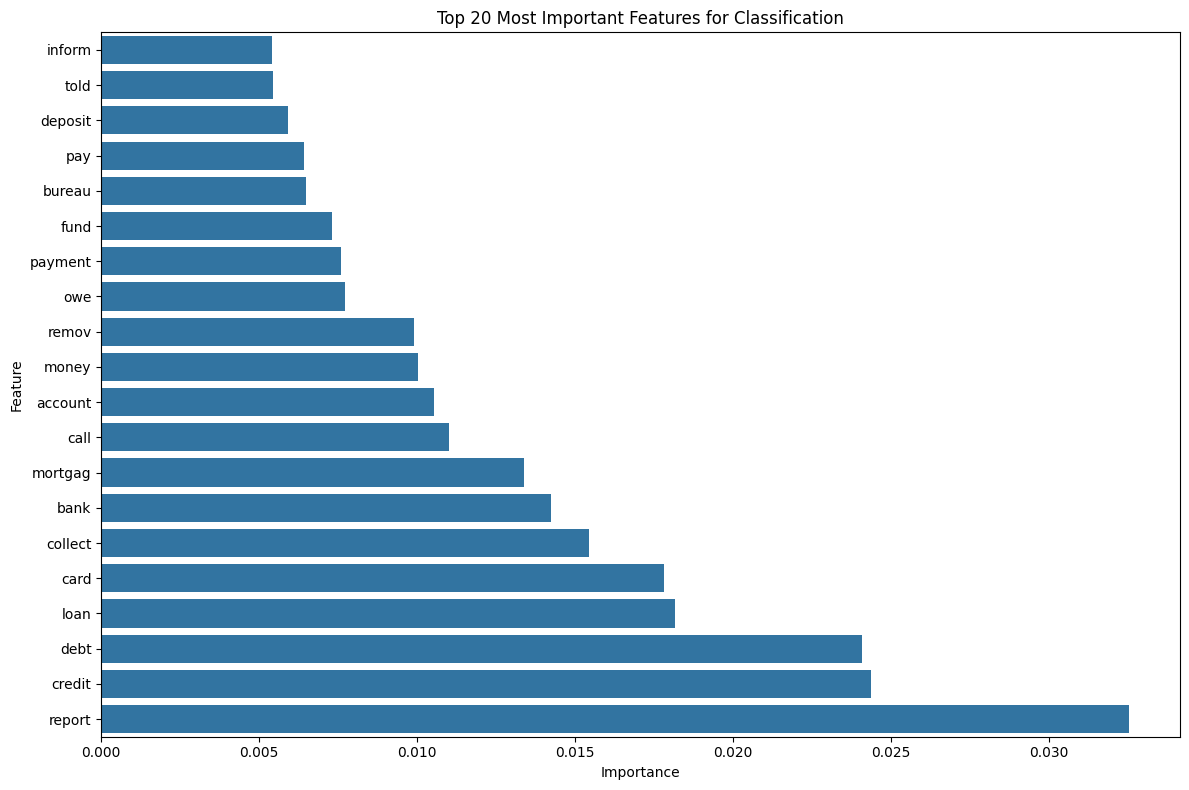

In [22]:
# Get feature importances from Random Forest model
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values('Importance', ascending=False)

print("Top 20 most important features:")
print(importance_df.head(20))

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Most Important Features for Classification')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

## 10. Model Testing with Sample Narratives

In [23]:

# Define a function to predict the product category for a new narrative
def predict_product_category(narrative, model, vectorizer, label_encoder):

    cleaned_narrative = clean_text(narrative)
    vectorized_narrative = vectorizer.transform([cleaned_narrative])
    prediction = model.predict(vectorized_narrative)[0]

    probabilities = model.predict_proba(vectorized_narrative)[0]
    max_prob = max(probabilities)

    predicted_category = label_encoder.inverse_transform([prediction])[0]

    return predicted_category, max_prob

# Test the model with some sample narratives from the test set
print("Testing the model with sample narratives from the test set:")
sample_indices = np.random.choice(X_test.shape[0], 5, replace=False)

for idx in sample_indices:
    # Get the actual narrative and product
    original_idx = y_test.index[idx]
    sample_narrative = df['narrative'].iloc[original_idx]
    actual_product = df['product'].iloc[original_idx]

    # Get model prediction
    predicted_product, confidence = predict_product_category(
        sample_narrative, best_model, tfidf_vectorizer, label_encoder
    )

    print(f"\nSample Narrative: {sample_narrative[:150]}...")
    print(f"Actual Product: {actual_product}")
    print(f"Predicted Product: {predicted_product}")
    print(f"Confidence: {confidence:.4f}")


10. Model Testing with Sample Narratives
--------------------------------------------------
Testing the model with sample narratives from the test set:

Sample Narrative: fraudulent inquiry authorize run credit want provide proof sign document stating approve...
Actual Product: credit_reporting
Predicted Product: credit_reporting
Confidence: 1.0000

Sample Narrative: consumer financial protection bureau fay servicing loan dear sir madam reaching consumer financial protection bureau assistance exhausted every mean c...
Actual Product: mortgages_and_loans
Predicted Product: mortgages_and_loans
Confidence: 0.8400

Sample Narrative: brother law applying heloc finance remodeling home excellent credit flawless payment history equity prior applying heloc home mortgage loan primary ho...
Actual Product: mortgages_and_loans
Predicted Product: mortgages_and_loans
Confidence: 0.8700

Sample Narrative: paid loan received escrow refund check bounced called different number associated company every

## 11. Testing with Custom Narratives

In [24]:
custom_narratives = [
    "I applied for a credit card last month and was approved. However, I've been charged an annual fee of $95 which was never disclosed during the application process. I've called customer service three times but they refuse to waive the fee.",

    "I've been trying to dispute an error on my credit report for six months. TransUnion keeps reporting a late payment on my mortgage from 2022, but I have bank statements proving the payment was made on time. I've sent all documentation but they refuse to correct it.",

    "A debt collector called my workplace five times last week trying to collect on a medical debt I don't recognize. They're threatening legal action if I don't pay $2,300 immediately. I've asked for verification of the debt but they haven't provided any documentation.",

    "My mortgage servicer has been placing my payments in suspense for the past three months instead of applying them to my loan. As a result, they're reporting me as late on payments even though I've paid on time. They also recently increased my escrow without explanation.",

    "I deposited a check for $1,500 into my checking account last Tuesday. The bank placed a 10-day hold on the funds even though I've been a customer for 15 years with no history of overdrafts. When I asked why, they said it was 'bank policy' but couldn't explain further."
]

# Test each narrative
for i, narrative in enumerate(custom_narratives):
    predicted_product, confidence = predict_product_category(
        narrative, best_model, tfidf_vectorizer, label_encoder
    )

    print(f"\nCustom Narrative {i+1}: {narrative[:150]}...")
    print(f"Predicted Product: {predicted_product}")
    print(f"Confidence: {confidence:.4f}")


11. Testing with Custom Narratives
--------------------------------------------------

Custom Narrative 1: I applied for a credit card last month and was approved. However, I've been charged an annual fee of $95 which was never disclosed during the applicat...
Predicted Product: credit_card
Confidence: 0.5900

Custom Narrative 2: I've been trying to dispute an error on my credit report for six months. TransUnion keeps reporting a late payment on my mortgage from 2022, but I hav...
Predicted Product: credit_reporting
Confidence: 0.7800

Custom Narrative 3: A debt collector called my workplace five times last week trying to collect on a medical debt I don't recognize. They're threatening legal action if I...
Predicted Product: debt_collection
Confidence: 0.8100

Custom Narrative 4: My mortgage servicer has been placing my payments in suspense for the past three months instead of applying them to my loan. As a result, they're repo...
Predicted Product: mortgages_and_loans
Confidence: 0.6

## 12. Save the Model for Future Use

In [30]:
import pickle
import joblib
import os

# Create a directory for saved models if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save the model using pickle
with open('saved_models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Save the TF-IDF vectorizer
with open('saved_models/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

# Save the label encoder
with open('saved_models/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

joblib.dump(best_model, 'saved_models/random_forest_model.joblib')
joblib.dump(tfidf_vectorizer, 'saved_models/tfidf_vectorizer.joblib')
joblib.dump(label_encoder, 'saved_models/label_encoder.joblib')

print("Model and preprocessing objects saved successfully!")



12. Save the Model for Future Use
--------------------------------------------------
Model and preprocessing objects saved successfully!

Example of loading and using the saved model:
```python
# Load the saved model and preprocessing objects
loaded_model = pickle.load(open('saved_models/random_forest_model.pkl', 'rb'))
loaded_vectorizer = pickle.load(open('saved_models/tfidf_vectorizer.pkl', 'rb'))
loaded_encoder = pickle.load(open('saved_models/label_encoder.pkl', 'rb'))

# Function to predict with loaded model
def predict_complaint_category(text):
    # Clean and preprocess the text
    cleaned_text = clean_text(text)
    # Vectorize the text
    vectorized_text = loaded_vectorizer.transform([cleaned_text])
    # Make prediction
    prediction = loaded_model.predict(vectorized_text)[0]
    # Get category name
    category = loaded_encoder.inverse_transform([prediction])[0]
    return category
```


## Conclusion and Recommendations

### Summary of Findings

- Successfully built an NLP classification model for bank customer complaints with **88.21% accuracy** using Random Forest  
- Model effectively categorizes complaints into **5 product classes**:
  - credit reporting  
  - debt collection  
  - mortgages and loans  
  - credit cards  
  - retail banking  
- **Credit reporting** complaints are identified with highest confidence (**88%**)  
- **Credit card** complaints are most challenging to classify (**44% confidence**)  
- Key predictive features include: *"report," "credit," "debt," "loan,"* and *"card"*  
- Sentiment analysis revealed varying emotional tones across product categories  

### Recommendations

#### Implementation Strategy

- Integrate model into complaint handling workflow for automated routing  
- Use confidence scores to determine when human review is necessary  

#### Model Improvements

- Collect additional credit card complaint data to improve classification  
- Consider incorporating sentiment features to enhance model performance  
- Explore more advanced NLP techniques for potentially higher accuracy  

#### Business Applications

- Develop dashboard to track complaint volumes and categories  
- Use insights to identify recurring customer issues  
- Create early warning system for emerging problem areas  
